In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['font.family'] = 'Arial'

In [3]:
import gc
import os
import sys

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from copy import deepcopy
from random import shuffle
from scipy.stats import spearmanr

from access_biology_data import lincs, properties
from access_science_shared import standardizer

sys.path.append('./../src/')
from aging_tools import inout, export

In [4]:
out_path = '191101_shavlakadze'

In [5]:
save_image=True

In [6]:
from access_science_shared import mapper

In [7]:
taxon_id = 10116

In [8]:
ref_genes = standardizer.reference_genes(taxon_id, 'orp')

In [9]:
mode = 'gene'

In [10]:
if mode=='validated_rna':

    pr = properties.genbank_validated_rna(taxon_id)[
        ['gene_ncbi', 'Genbank_validated_RNA: full_SumACGT']].rename(columns={
        'Genbank_validated_RNA: full_SumACGT': 'length'
    })

    pr.loc[:, 'log_length'] = np.log10(pr['length'])

elif mode=='gene':
    
    pr = properties.genbank_gene(taxon_id=10116)[['gene_ncbi', 'Genbank__gene: SumACGT']].rename(columns={
        'Genbank__gene: SumACGT': 'length'
    })
    pr.loc[:, 'log_length'] = np.log10(pr['length'])
    
else:
    raise AssertionError("something wrong")

In [11]:
p = inout.get_internal_path(
    'datasets/general/resources/publications/shavlakadze_2019/1-s2.0-S2211124719310915-mmc2.xlsx')

In [12]:
df_out_p = pd.DataFrame()
df_out_r = pd.DataFrame()

In [13]:
tissues = [
    'Gastrocnemius - all genes',
    'Hippocampus - all genes',
    'Kidney - all genes',
    'Liver - all genes',
]

In [14]:
ages = [
    'Age1.9Vs6Mo.log2FC',
    'Age2.12Vs6Mo.log2FC',
    'Age3.18Vs6Mo.log2FC',
    'Age4.21Vs6Mo.log2FC',
    'Age5.24Vs6Mo.log2FC',
    'Age6.27Vs6Mo.log2FC',
]

In [15]:
for tissue in tissues:
    for age in ages:

        df = pd.read_excel(
            p,
            sheet_name=tissue,
            usecols=['ensembl_gene_id', age],
            skiprows=1
        )


        df = df.rename(columns={'ensembl_gene_id': 'gene_ensembl'})
        df = mapper.gene_ensembl_2_gene_ncbi_unambiguously(df, taxon_id)
        df = df[df.index.isin(ref_genes)]
        df = pd.merge(df.reset_index(), pr)

        r, pv = spearmanr(df['length'], df[age])

        short_tissue = tissue.replace(' - all genes', '')
        short_age = age[5:].replace('Vs6Mo.log2FC', '')

        df_out_p.loc[short_tissue, short_age] = pv
        df_out_r.loc[short_tissue, short_age] = r

In [16]:
df_out_r   # correlation between length and fold change

,9,12,18,21,24,27
Gastrocnemius,-0.086823,0.010790,-0.050794,-0.184320,-0.098914,-0.048339
Hippocampus,-0.109522,-0.151786,-0.088779,-0.134685,-0.238819,-0.245481
Kidney,0.007486,-0.141715,-0.108766,-0.024704,-0.006301,-0.018830
Liver,-0.086434,0.109151,-0.075076,-0.022295,-0.070677,-0.028387


In [17]:
df_out_p   # p-values of correlation between length and fold change

,9,12,18,21,24,27
Gastrocnemius,1.788606e-15,3.237388e-01,3.348793e-06,7.886866e-65,1.210352e-19,9.718771e-06
Hippocampus,5.956547e-27,1.821292e-50,3.187761e-18,5.161316e-40,2.622550e-124,1.901304e-131
Kidney,4.684281e-01,2.752665e-43,4.326750e-26,1.671824e-02,5.417151e-01,6.818404e-02
Liver,3.011545e-15,1.953077e-23,7.363396e-12,4.217948e-02,1.133569e-10,9.678764e-03


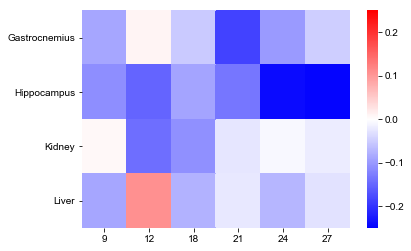

In [18]:
sns.heatmap(df_out_r, vmin=-0.25, vmax=0.25, cmap='bwr')


if save_image:
    export.export_image('{}/{}_imbalance.pdf'.format(out_path, mode))

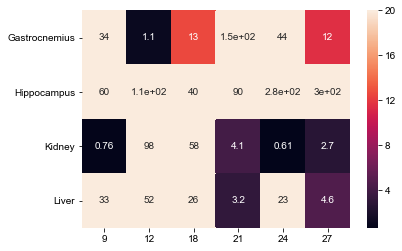

In [19]:
sns.heatmap(df_out_p.apply(lambda x: -np.log(x)), vmax=20, annot=True)

if save_image:
    export.export_image('{}/{}_pvalues.pdf'.format(out_path, mode))